In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
# pd.set_option('display.max_columns', 1000)
# pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('..')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from project.ranker.ranker import RankingPredictor

In [3]:
%%time
rp = Pipeline([
    ('scale', StandardScaler()),
    ('estimator', RankingPredictor("ma_100", n_neighbors=15)),
])
df_mf, df_rank, df_scores, df_fold_scores = rp.named_steps['estimator'].get_data()

CPU times: user 54.9 s, sys: 3.67 s, total: 58.5 s
Wall time: 58.3 s


In [7]:
from sklearn.model_selection import train_test_split

X_train, _, y_train, _, y_scores_train, _ = train_test_split(df_mf.values,
                                                             df_rank.values,
                                                             df_scores.values,
                                                             test_size=0)
X_train.shape, y_train.shape

((60, 39), (60, 13))

In [191]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=2, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train.shape[1] - y_train + 1, y_scores_train, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, verbose_eval=False)

Fold   1 | #Est:   2 | Trn_Spearman:  0.2977 | Val_Spearman:  0.2592 | Trn_ACCLoss:  0.0370 | Val_ACCLoss:  0.0682 | Trn_NDCG:  0.7352 | Val_NDCG:  0.7133
Fold   2 | #Est:   6 | Trn_Spearman:  0.3516 | Val_Spearman:  0.2408 | Trn_ACCLoss:  0.0152 | Val_ACCLoss:  0.0731 | Trn_NDCG:  0.7980 | Val_NDCG:  0.5778
Fold   3 | #Est:  24 | Trn_Spearman:  0.4100 | Val_Spearman:  0.2582 | Trn_ACCLoss:  0.0124 | Val_ACCLoss:  0.0797 | Trn_NDCG:  0.8507 | Val_NDCG:  0.5944
Fold   4 | #Est:   3 | Trn_Spearman:  0.3758 | Val_Spearman:  0.0321 | Trn_ACCLoss:  0.0202 | Val_ACCLoss:  0.0715 | Trn_NDCG:  0.7622 | Val_NDCG:  0.5557
Fold   5 | #Est:  23 | Trn_Spearman:  0.4199 | Val_Spearman:  0.0513 | Trn_ACCLoss:  0.0098 | Val_ACCLoss:  0.1202 | Trn_NDCG:  0.8485 | Val_NDCG:  0.5623
Fold   6 | #Est:  23 | Trn_Spearman:  0.4028 | Val_Spearman:  0.1877 | Trn_ACCLoss:  0.0153 | Val_ACCLoss:  0.0274 | Trn_NDCG:  0.8131 | Val_NDCG:  0.6443
Fold   7 | #Est:  98 | Trn_Spearman:  0.4237 | Val_Spearman: -0.0339 |

In [190]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train.shape[1] - y_train + 1, y_scores_train, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, verbose_eval=False)

Fold   1 | #Est:   2 | Trn_Spearman:  0.2977 | Val_Spearman:  0.2592 | Trn_ACCLoss:  0.0370 | Val_ACCLoss:  0.0682 | Trn_NDCG:  0.7352 | Val_NDCG:  0.7133
Fold   2 | #Est:   6 | Trn_Spearman:  0.3516 | Val_Spearman:  0.2408 | Trn_ACCLoss:  0.0152 | Val_ACCLoss:  0.0731 | Trn_NDCG:  0.7980 | Val_NDCG:  0.5778
Fold   3 | #Est:  24 | Trn_Spearman:  0.4100 | Val_Spearman:  0.2582 | Trn_ACCLoss:  0.0124 | Val_ACCLoss:  0.0797 | Trn_NDCG:  0.8507 | Val_NDCG:  0.5944
Fold   4 | #Est:   3 | Trn_Spearman:  0.3758 | Val_Spearman:  0.0321 | Trn_ACCLoss:  0.0202 | Val_ACCLoss:  0.0715 | Trn_NDCG:  0.7622 | Val_NDCG:  0.5557
Fold   5 | #Est:  23 | Trn_Spearman:  0.4199 | Val_Spearman:  0.0513 | Trn_ACCLoss:  0.0098 | Val_ACCLoss:  0.1202 | Trn_NDCG:  0.8485 | Val_NDCG:  0.5623
Fold   6 | #Est:  23 | Trn_Spearman:  0.4028 | Val_Spearman:  0.1877 | Trn_ACCLoss:  0.0153 | Val_ACCLoss:  0.0274 | Trn_NDCG:  0.8131 | Val_NDCG:  0.6443
Fold   7 | #Est:  98 | Trn_Spearman:  0.4237 | Val_Spearman: -0.0339 |

In [68]:
from project.ranker.ltr_rankers import wide2long
X, y = wide2long(X_train, y_train)
X.shape, y.shape

((780, 40), (780,))

In [170]:
from scipy.stats import rankdata
y_pred = np.array([rankdata(models[0].predict(wide2long(x_[None,:], y_[None,:])[0]), 
                               method='ordinal') for x_, y_ in zip(X_train, y_train)])
y_pred.shape

(60, 13)

In [173]:
13 - y_train[0] + 1

array([12,  9,  8,  3,  1, 11, 10,  2, 13,  4,  6,  5,  7])

In [172]:
y_pred[0]

array([ 1,  2,  3,  4,  5,  8,  9, 10, 11, 12, 13,  6,  7])

In [174]:
from scipy.stats import spearmanr
spearmanr(13 - y_train[0] + 1, y_pred[0])

SpearmanrResult(correlation=-0.10989010989010989, pvalue=0.7208097995138618)

## Ranking, Regression, Classification

In [195]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=2, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train.shape[1] - y_train + 1, y_scores_train, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, verbose_eval=False)

Fold   1 | #Est:   2 | Trn_Spearman:  0.2977 | Val_Spearman:  0.2592 | Trn_ACCLoss:  0.0370 | Val_ACCLoss:  0.0682 | Trn_NDCG:  0.7352 | Val_NDCG:  0.7133
Fold   2 | #Est:   6 | Trn_Spearman:  0.3516 | Val_Spearman:  0.2408 | Trn_ACCLoss:  0.0152 | Val_ACCLoss:  0.0731 | Trn_NDCG:  0.7980 | Val_NDCG:  0.5778
Fold   3 | #Est:  24 | Trn_Spearman:  0.4100 | Val_Spearman:  0.2582 | Trn_ACCLoss:  0.0124 | Val_ACCLoss:  0.0797 | Trn_NDCG:  0.8507 | Val_NDCG:  0.5944
Fold   4 | #Est:   3 | Trn_Spearman:  0.3758 | Val_Spearman:  0.0321 | Trn_ACCLoss:  0.0202 | Val_ACCLoss:  0.0715 | Trn_NDCG:  0.7622 | Val_NDCG:  0.5557
Fold   5 | #Est:  23 | Trn_Spearman:  0.4199 | Val_Spearman:  0.0513 | Trn_ACCLoss:  0.0098 | Val_ACCLoss:  0.1202 | Trn_NDCG:  0.8485 | Val_NDCG:  0.5623
Fold   6 | #Est:  23 | Trn_Spearman:  0.4028 | Val_Spearman:  0.1877 | Trn_ACCLoss:  0.0153 | Val_ACCLoss:  0.0274 | Trn_NDCG:  0.8131 | Val_NDCG:  0.6443
Fold   7 | #Est:  98 | Trn_Spearman:  0.4237 | Val_Spearman: -0.0339 |

In [194]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=2, random_state=42)
params = {'objective': 'regression', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train.shape[1] - y_train + 1, y_scores_train, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, verbose_eval=False)

Fold   1 | #Est:   2 | Trn_Spearman:  0.4294 | Val_Spearman:  0.3901 | Trn_ACCLoss:  0.0621 | Val_ACCLoss:  0.1853 | Trn_NDCG:  0.6465 | Val_NDCG:  0.6706
Fold   2 | #Est:  72 | Trn_Spearman:  0.5380 | Val_Spearman:  0.2903 | Trn_ACCLoss:  0.0387 | Val_ACCLoss:  0.1764 | Trn_NDCG:  0.7101 | Val_NDCG:  0.6252
Fold   3 | #Est:  30 | Trn_Spearman:  0.4639 | Val_Spearman:  0.1951 | Trn_ACCLoss:  0.0622 | Val_ACCLoss:  0.1125 | Trn_NDCG:  0.6839 | Val_NDCG:  0.5400
Fold   4 | #Est:  32 | Trn_Spearman:  0.4380 | Val_Spearman:  0.2601 | Trn_ACCLoss:  0.0456 | Val_ACCLoss:  0.0480 | Trn_NDCG:  0.6749 | Val_NDCG:  0.7206
Fold   5 | #Est:  15 | Trn_Spearman:  0.4373 | Val_Spearman:  0.0595 | Trn_ACCLoss:  0.0644 | Val_ACCLoss:  0.1327 | Trn_NDCG:  0.6335 | Val_NDCG:  0.5640
Fold   6 | #Est:   1 | Trn_Spearman:  0.2000 | Val_Spearman: -0.0568 | Trn_ACCLoss:  0.1398 | Val_ACCLoss:  0.0802 | Trn_NDCG:  0.5635 | Val_NDCG:  0.5381
Fold   7 | #Est:   3 | Trn_Spearman:  0.4399 | Val_Spearman:  0.0330 |

In [196]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=2, random_state=42)
params = {'objective': 'binary', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train.shape[1] - y_train + 1, y_scores_train, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, verbose_eval=False)

Fold   1 | #Est:   1 | Trn_Spearman: -0.0954 | Val_Spearman:  0.0375 | Trn_ACCLoss:  0.1136 | Val_ACCLoss:  0.1499 | Trn_NDCG:  0.5295 | Val_NDCG:  0.5097
Fold   2 | #Est:   1 | Trn_Spearman: -0.0900 | Val_Spearman: -0.0110 | Trn_ACCLoss:  0.1129 | Val_ACCLoss:  0.1561 | Trn_NDCG:  0.5317 | Val_NDCG:  0.4901
Fold   3 | #Est:   1 | Trn_Spearman: -0.0665 | Val_Spearman: -0.2225 | Trn_ACCLoss:  0.1216 | Val_ACCLoss:  0.0782 | Trn_NDCG:  0.5195 | Val_NDCG:  0.5999
Fold   4 | #Est:   1 | Trn_Spearman: -0.0980 | Val_Spearman:  0.0604 | Trn_ACCLoss:  0.1218 | Val_ACCLoss:  0.0761 | Trn_NDCG:  0.5231 | Val_NDCG:  0.5679
Fold   5 | #Est:   1 | Trn_Spearman: -0.0736 | Val_Spearman: -0.1593 | Trn_ACCLoss:  0.1107 | Val_ACCLoss:  0.1763 | Trn_NDCG:  0.5227 | Val_NDCG:  0.5713
Fold   6 | #Est:   1 | Trn_Spearman: -0.0648 | Val_Spearman: -0.2381 | Trn_ACCLoss:  0.1159 | Val_ACCLoss:  0.1295 | Trn_NDCG:  0.5292 | Val_NDCG:  0.5131
Fold   7 | #Est:   1 | Trn_Spearman: -0.1095 | Val_Spearman:  0.1639 |

## 10 runs - 10 folds

In [224]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train.shape[1] - y_train + 1, y_scores_train, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, verbose_eval=False)

Fold   1 | #Est:   2 | Trn_Spearman:  0.2977 | Val_Spearman:  0.2592 | Trn_ACCLoss:  0.0370 | Val_ACCLoss:  0.0682 | Trn_NDCG:  0.7352 | Val_NDCG:  0.7133
Fold   2 | #Est:   6 | Trn_Spearman:  0.3516 | Val_Spearman:  0.2408 | Trn_ACCLoss:  0.0152 | Val_ACCLoss:  0.0731 | Trn_NDCG:  0.7980 | Val_NDCG:  0.5778
Fold   3 | #Est:  24 | Trn_Spearman:  0.4100 | Val_Spearman:  0.2582 | Trn_ACCLoss:  0.0124 | Val_ACCLoss:  0.0797 | Trn_NDCG:  0.8507 | Val_NDCG:  0.5944
Fold   4 | #Est:   3 | Trn_Spearman:  0.3758 | Val_Spearman:  0.0321 | Trn_ACCLoss:  0.0202 | Val_ACCLoss:  0.0715 | Trn_NDCG:  0.7622 | Val_NDCG:  0.5557
Fold   5 | #Est:  23 | Trn_Spearman:  0.4199 | Val_Spearman:  0.0513 | Trn_ACCLoss:  0.0098 | Val_ACCLoss:  0.1202 | Trn_NDCG:  0.8485 | Val_NDCG:  0.5623
Fold   6 | #Est:  23 | Trn_Spearman:  0.4028 | Val_Spearman:  0.1877 | Trn_ACCLoss:  0.0153 | Val_ACCLoss:  0.0274 | Trn_NDCG:  0.8131 | Val_NDCG:  0.6443
Fold   7 | #Est:  98 | Trn_Spearman:  0.4237 | Val_Spearman: -0.0339 |

In [225]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {'objective': 'regression', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train.shape[1] - y_train + 1, y_scores_train, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, verbose_eval=False)

Fold   1 | #Est:   2 | Trn_Spearman:  0.4294 | Val_Spearman:  0.3901 | Trn_ACCLoss:  0.0621 | Val_ACCLoss:  0.1853 | Trn_NDCG:  0.6465 | Val_NDCG:  0.6706
Fold   2 | #Est:  72 | Trn_Spearman:  0.5380 | Val_Spearman:  0.2903 | Trn_ACCLoss:  0.0387 | Val_ACCLoss:  0.1764 | Trn_NDCG:  0.7101 | Val_NDCG:  0.6252
Fold   3 | #Est:  30 | Trn_Spearman:  0.4639 | Val_Spearman:  0.1951 | Trn_ACCLoss:  0.0622 | Val_ACCLoss:  0.1125 | Trn_NDCG:  0.6839 | Val_NDCG:  0.5400
Fold   4 | #Est:  32 | Trn_Spearman:  0.4380 | Val_Spearman:  0.2601 | Trn_ACCLoss:  0.0456 | Val_ACCLoss:  0.0480 | Trn_NDCG:  0.6749 | Val_NDCG:  0.7206
Fold   5 | #Est:  15 | Trn_Spearman:  0.4373 | Val_Spearman:  0.0595 | Trn_ACCLoss:  0.0644 | Val_ACCLoss:  0.1327 | Trn_NDCG:  0.6335 | Val_NDCG:  0.5640
Fold   6 | #Est:   1 | Trn_Spearman:  0.2000 | Val_Spearman: -0.0568 | Trn_ACCLoss:  0.1398 | Val_ACCLoss:  0.0802 | Trn_NDCG:  0.5635 | Val_NDCG:  0.5381
Fold   7 | #Est:   3 | Trn_Spearman:  0.4399 | Val_Spearman:  0.0330 |

In [226]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=10, random_state=42)
params = {'objective': 'binary', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train.shape[1] - y_train + 1, y_scores_train, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, verbose_eval=False)

Fold   1 | #Est:   1 | Trn_Spearman: -0.0954 | Val_Spearman:  0.0375 | Trn_ACCLoss:  0.1136 | Val_ACCLoss:  0.1499 | Trn_NDCG:  0.5295 | Val_NDCG:  0.5097
Fold   2 | #Est:   1 | Trn_Spearman: -0.0900 | Val_Spearman: -0.0110 | Trn_ACCLoss:  0.1129 | Val_ACCLoss:  0.1561 | Trn_NDCG:  0.5317 | Val_NDCG:  0.4901
Fold   3 | #Est:   1 | Trn_Spearman: -0.0665 | Val_Spearman: -0.2225 | Trn_ACCLoss:  0.1216 | Val_ACCLoss:  0.0782 | Trn_NDCG:  0.5195 | Val_NDCG:  0.5999
Fold   4 | #Est:   1 | Trn_Spearman: -0.0980 | Val_Spearman:  0.0604 | Trn_ACCLoss:  0.1218 | Val_ACCLoss:  0.0761 | Trn_NDCG:  0.5231 | Val_NDCG:  0.5679
Fold   5 | #Est:   1 | Trn_Spearman: -0.0736 | Val_Spearman: -0.1593 | Trn_ACCLoss:  0.1107 | Val_ACCLoss:  0.1763 | Trn_NDCG:  0.5227 | Val_NDCG:  0.5713
Fold   6 | #Est:   1 | Trn_Spearman: -0.0648 | Val_Spearman: -0.2381 | Trn_ACCLoss:  0.1159 | Val_ACCLoss:  0.1295 | Trn_NDCG:  0.5292 | Val_NDCG:  0.5131
Fold   7 | #Est:   1 | Trn_Spearman: -0.1095 | Val_Spearman:  0.1639 |

In [ ]:
# LambdaRank
Trn_Spearman:  0.3714 +/-0.0634 | Val_Spearman:  0.0922 +/-0.1403
Trn_ACCLoss:   0.0254 +/-0.0194 | Val_ACCLoss:   0.0921 +/-0.0564
Trn_NDCG:      0.7845 +/-0.0671 | Val_NDCG:      0.6157 +/-0.0555

# Regression        
Trn_Spearman:  0.3531 +/-0.1215 | Val_Spearman:  0.1699 +/-0.1319
Trn_ACCLoss:   0.0847 +/-0.0324 | Val_ACCLoss:   0.1166 +/-0.0723
Trn_NDCG:      0.6294 +/-0.0510 | Val_NDCG:      0.5891 +/-0.0665
        
# Binary Classification        
Trn_Spearman: -0.0821 +/-0.0170 | Val_Spearman: -0.0821 +/-0.1533
Trn_ACCLoss:   0.1172 +/-0.0064 | Val_ACCLoss:   0.1172 +/-0.0573
Trn_NDCG:      0.5275 +/-0.0054 | Val_NDCG:      0.5275 +/-0.0486   

## New ranking

In [256]:
%%time
from sklearn.model_selection import train_test_split
rp = Pipeline([
    ('scale', StandardScaler()),
    ('estimator', RankingPredictor("ma_100", n_neighbors=15)),
])
df_mf, df_rank, df_scores, _ = rp.named_steps['estimator'].get_data()

df_mf = df_mf.sort_index()
df_rank = df_rank.sort_index()
df_scores = df_scores.sort_index()

X_train, _, y_train, _, y_scores_train, _ = train_test_split(df_mf.values,
                                                             df_rank.values,
                                                             df_scores.values,
                                                             test_size=0,
                                                             random_state=42)
print(X_train.shape, y_train.shape, y_scores_train.shape)

(60, 39) (60, 13) (60, 13)
CPU times: user 56 s, sys: 2.85 s, total: 58.8 s
Wall time: 58.6 s


In [257]:
df_mf.head()

,X_correlation_max,X_correlation_mean,X_correlation_min,X_covariance_max,X_covariance_mean,X_covariance_min,X_exp_var_max,X_exp_var_n_t80_cumsum,X_kurtosis_max,X_kurtosis_mean,...,X_stand_dev_min,X_std_covariance_max,X_std_covariance_mean,X_std_covariance_min,X_std_exp_var_max,X_var_coef_max,X_var_coef_mean,X_var_coef_min,y_norm_class_entropy_none,y_num_classes_none
dataset,,,,,,,,,,,,,,,,,,,,,
dataset_adrenal_dahia,0.999667,0.234430,-0.812136,1.623430e+07,8.504074e+04,-8.036567e+06,0.496436,7,70.965057,2.485264,...,214.688210,0.999667,0.234430,-0.812136,0.365666,3.549178,0.482764,0.185567,0.660107,2
dataset_bladder_blaveri,0.997000,0.016637,-0.807860,5.466345e+00,1.751232e-02,-2.651214e+00,0.138072,18,28.838864,1.122035,...,0.598977,0.997000,0.016637,-0.807860,0.136261,27.794131,9.528645,6.472099,0.909736,2
dataset_bladder_dyrskjot,0.999769,0.001990,-0.844262,7.591545e+06,9.163676e+03,-1.122898e+06,0.512813,7,34.977662,3.379040,...,84.187356,0.999769,0.001990,-0.844262,0.191450,4.946015,0.537739,0.134327,0.944115,3
dataset_bladder_sanchez-carbayo,0.998971,0.024284,-0.775310,2.772741e+09,1.090141e+06,-3.381016e+08,0.321690,9,150.678960,11.099998,...,1078.944434,0.998971,0.024284,-0.775310,0.195417,9.586933,0.614698,0.173814,0.920448,3
dataset_breast_desmedt,0.992741,0.016365,-0.841027,1.122206e+01,4.959717e-02,-5.426657e+00,0.096048,108,23.905114,-0.024238,...,1.456582,0.992741,0.016365,-0.841027,0.082234,0.680823,0.300534,0.254868,0.790646,2


In [258]:
df_rank.head()

,minmax_chi_square_linearSVC,minmax_chi_square_logReg,minmax_chi_square_naiveBayes,minmax_fisher_linearSVC,minmax_fisher_logReg,minmax_fisher_naiveBayes,minmax_random_forest_linearSVC,minmax_random_forest_logReg,minmax_random_forest_naiveBayes,minmax_reliefF_linearSVC,minmax_reliefF_logReg,minmax_reliefF_naiveBayes,minmax_rfe_svc_linearSVC
dataset,,,,,,,,,,,,,
dataset_adrenal_dahia,7,12,4,6,11,2,9,10,3,5,13,1,8
dataset_bladder_blaveri,3,7,2,4,9,1,11,13,10,6,8,5,12
dataset_bladder_dyrskjot,8,2,10,1,3,6,7,4,11,12,5,13,9
dataset_bladder_sanchez-carbayo,10,6,13,4,7,12,3,2,1,11,5,9,8
dataset_breast_desmedt,11,13,2,9,12,1,6,10,3,5,8,4,7


In [259]:
df_scores.head()

,minmax_chi_square_linearSVC,minmax_chi_square_logReg,minmax_chi_square_naiveBayes,minmax_fisher_linearSVC,minmax_fisher_logReg,minmax_fisher_naiveBayes,minmax_random_forest_linearSVC,minmax_random_forest_logReg,minmax_random_forest_naiveBayes,minmax_reliefF_linearSVC,minmax_reliefF_logReg,minmax_reliefF_naiveBayes,minmax_rfe_svc_linearSVC
dataset,,,,,,,,,,,,,
dataset_adrenal_dahia,0.759843,0.698793,0.808294,0.777764,0.702048,0.848965,0.725282,0.705008,0.821320,0.789216,0.694388,0.870075,0.749986
dataset_bladder_blaveri,0.592553,0.539299,0.600404,0.590940,0.527914,0.613476,0.511423,0.440760,0.523538,0.565467,0.533838,0.581609,0.509370
dataset_bladder_dyrskjot,0.796359,0.848382,0.791270,0.879208,0.813103,0.802400,0.797196,0.810595,0.784913,0.779231,0.805368,0.751862,0.792850
dataset_bladder_sanchez-carbayo,0.848526,0.864391,0.807442,0.867562,0.861703,0.816620,0.873509,0.874331,0.882191,0.843806,0.867216,0.860360,0.861079
dataset_breast_desmedt,0.426212,0.396177,0.683841,0.452257,0.412470,0.685199,0.499915,0.439650,0.672164,0.530061,0.474212,0.666339,0.479602


In [244]:
%%time
import lightgbm
from project.ranker.ltr_rankers import cv_lgbm
from sklearn.model_selection import RepeatedKFold
kfolds = RepeatedKFold(10, n_repeats=2, random_state=42)
params = {'objective': 'lambdarank', 
          'metric': 'ndcg', 
          'learning_rate': 1e-3,
#           'num_leaves': 50,
          'ndcg_at': y_train.shape[1],
          'min_data_in_leaf': 3,
          'min_sum_hessian_in_leaf': 1e-4}
results, models = cv_lgbm(lightgbm, X_train, y_train, y_scores_train, kfolds, 
                  params, num_rounds=1000, early_stopping_rounds=50, verbose_eval=False)

Fold   1 | #Est: 167 | Trn_Spearman:  0.4662 | Val_Spearman:  0.2747 | Trn_ACCLoss:  0.2572 | Val_ACCLoss:  0.1465 | Trn_NDCG:  0.8668 | Val_NDCG:  0.6631
Fold   2 | #Est: 137 | Trn_Spearman:  0.4648 | Val_Spearman:  0.2253 | Trn_ACCLoss:  0.2722 | Val_ACCLoss:  0.1327 | Trn_NDCG:  0.9006 | Val_NDCG:  0.5868
Fold   3 | #Est:   6 | Trn_Spearman:  0.4247 | Val_Spearman:  0.0174 | Trn_ACCLoss:  0.2028 | Val_ACCLoss:  0.1647 | Trn_NDCG:  0.7852 | Val_NDCG:  0.5847
Fold   4 | #Est:  63 | Trn_Spearman:  0.4522 | Val_Spearman:  0.2701 | Trn_ACCLoss:  0.2423 | Val_ACCLoss:  0.2671 | Trn_NDCG:  0.8327 | Val_NDCG:  0.5628
Fold   5 | #Est:   4 | Trn_Spearman:  0.3730 | Val_Spearman:  0.3407 | Trn_ACCLoss:  0.2036 | Val_ACCLoss:  0.2660 | Trn_NDCG:  0.7445 | Val_NDCG:  0.6464
Fold   6 | #Est:  43 | Trn_Spearman:  0.4259 | Val_Spearman:  0.0907 | Trn_ACCLoss:  0.2504 | Val_ACCLoss:  0.1931 | Trn_NDCG:  0.8214 | Val_NDCG:  0.6560
Fold   7 | #Est:   4 | Trn_Spearman:  0.4192 | Val_Spearman:  0.0092 |

In [245]:
from sklearn.model_selection import KFold
from project.ranker.ltr_rankers import cv_random
from project.ranker.ranker import RandomRankingPredictor

rr = RandomRankingPredictor()
kfolds = RepeatedKFold(10, n_repeats=2, random_state=42)
results = cv_random(rr, X_train, y_train, y_scores_train, kfolds)

Fold   1 | Trn_Spearman: -0.0295 | Val_Spearman:  0.0467 | Trn_ACCLoss:  0.1602 | Val_ACCLoss:  0.0378
Fold   2 | Trn_Spearman:  0.0124 | Val_Spearman: -0.1795 | Trn_ACCLoss:  0.1825 | Val_ACCLoss:  0.0615
Fold   3 | Trn_Spearman:  0.0582 | Val_Spearman:  0.2042 | Trn_ACCLoss:  0.1225 | Val_ACCLoss:  0.3269
Fold   4 | Trn_Spearman:  0.0050 | Val_Spearman: -0.0824 | Trn_ACCLoss:  0.1041 | Val_ACCLoss:  0.1993
Fold   5 | Trn_Spearman:  0.0092 | Val_Spearman:  0.2216 | Trn_ACCLoss:  0.1195 | Val_ACCLoss:  0.2870
Fold   6 | Trn_Spearman: -0.0287 | Val_Spearman: -0.0934 | Trn_ACCLoss:  0.1191 | Val_ACCLoss:  0.2107
Fold   7 | Trn_Spearman: -0.0011 | Val_Spearman:  0.1493 | Trn_ACCLoss:  0.1530 | Val_ACCLoss:  0.0948
Fold   8 | Trn_Spearman: -0.0122 | Val_Spearman: -0.1117 | Trn_ACCLoss:  0.1244 | Val_ACCLoss:  0.0897
Fold   9 | Trn_Spearman:  0.0403 | Val_Spearman:  0.0549 | Trn_ACCLoss:  0.1592 | Val_ACCLoss:  0.1748
Fold  10 | Trn_Spearman:  0.0078 | Val_Spearman:  0.0311 | Trn_ACCLoss:  

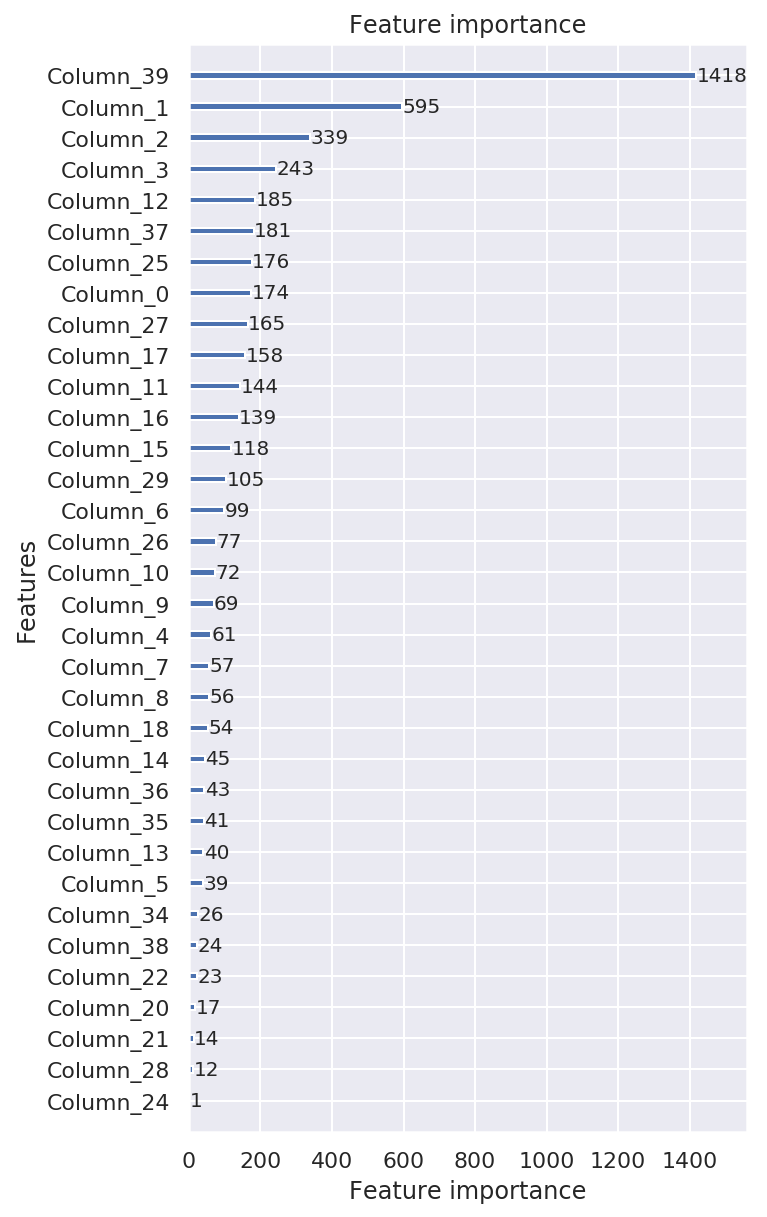

In [241]:
lightgbm.plot_importance(models[0], figsize=(5,10))

In [242]:
from project.ranker.ltr_rankers import wide2long
X, y = wide2long(X_train, y_train)
X.shape, y.shape

((780, 40), (780,))

In [243]:
X_train[0]

array([ 9.98416164e-01,  9.78076943e-02, -9.34152081e-01,  1.14126033e+01,
        1.03748316e-01, -5.50224752e+00,  4.41639318e-01,  9.00000000e+00,
        2.32892271e+01,  4.92152089e-02, -1.80301868e+00,  1.36957480e-01,
        5.97068712e-03, -1.20713751e-01,  4.48244710e-01,  3.89687380e-01,
        2.50037194e-01,  1.45487462e-01,  8.69653483e-01,  5.58000408e-01,
        3.24679947e-01,  2.00000000e+03,  5.60000000e+01,  3.57142857e+01,
        4.93650377e+00,  3.12122175e-01, -2.12695434e+00,  3.44260222e+00,
        1.16430064e+00,  8.42348126e-01,  9.98416164e-01,  9.78076943e-02,
       -9.34152081e-01,  4.07612984e-01,  4.96609925e-01,  1.67955290e-01,
        1.21512279e-01,  9.78520532e-01,  4.00000000e+00])